## ViT Qualitative

In [1]:
import os
#virtually move to parent directory
os.chdir("..")

import torch

import matplotlib
from matplotlib import pyplot as plt

import utils
import data_utils
import similarity

## Settings

In [2]:
clip_name = 'ViT-B/16'
d_probe = 'imagenet_broden'
concept_set = 'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

In [3]:
target_name = 'vit_b_16'
target_layer = 'encoder'

## Run CLIP-Dissect

In [4]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

In [5]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                                text_save_name, similarity_fn, device=device)

100%|██████████| 768/768 [00:05<00:00, 149.25it/s]


torch.Size([768, 20000])


## Visualize

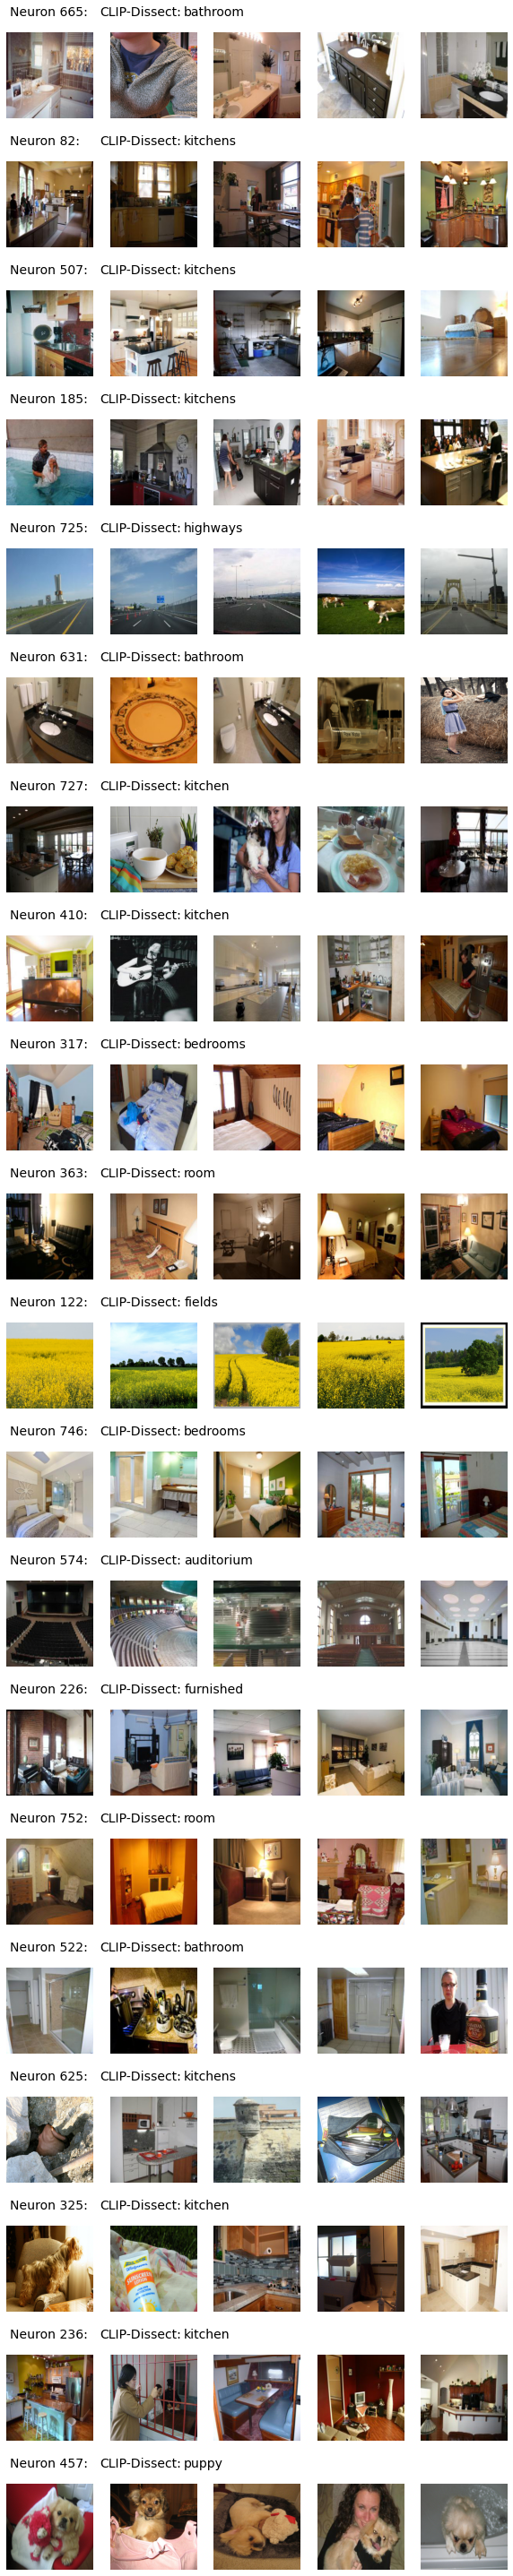

In [6]:
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)
neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:20]
font_size = 14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()